## Importing libraries...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string 
import os
import torch
from textblob import TextBlob
import nltk
import spacy

In [2]:
data=pd.read_csv('/kaggle/input/cyberbullying-tweets/cyberbullying_tweets.csv')
data.head(10)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


### Remove duplicated tweets

In [4]:
data.duplicated().sum()

36

In [5]:
data = data[~data.duplicated()]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47656 non-null  object
 1   cyberbullying_type  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [7]:
print(data['cyberbullying_type'].value_counts())

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64


In [8]:
print(data['cyberbullying_type'].unique())

['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


In [9]:
print("Total classes:", data['cyberbullying_type'].nunique())

Total classes: 6


## Checking Missing Values

In [10]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

# Preprocessing of Text

In [11]:
data['tweet_text'][3]

'@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.'

In [12]:
data['tweet_text'][3].lower()

'@jason_gio meh. :p  thanks for the heads up, but not too concerned about another angry dude on twitter.'

In [13]:
def to_lowercase(text):
    return text.lower()

data['tweet_text']=data['tweet_text'].apply(to_lowercase)

In [14]:
data

,tweet_text,cyberbullying_type
0,"in other words #katandandre, your food was cra...",not_cyberbullying
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying
...,...,...
47687,"black ppl aren't expected to do anything, depe...",ethnicity
47688,turner did not withhold his disappointment. tu...,ethnicity
47689,i swear to god. this dumb nigger bitch. i have...,ethnicity
47690,yea fuck you rt @therealexel: if youre a nigge...,ethnicity


#### Remove HTML tags

In [15]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')  
    return pattern.sub(r'', text) 

In [16]:
data['tweet_text']=data['tweet_text'].apply(remove_html_tags)

#### Remove URLs

In [17]:
def remove_urls(text):
    pattern=re.compile(r'http\S+|www\S+')
    return pattern.sub(r'', text)

In [18]:
# Example
sample = "Check this out http://example.com and also www.test.com"
print(remove_urls(sample))

Check this out  and also 


In [19]:
# Apply to dataset
data['tweet_text'] = data['tweet_text'].apply(remove_urls)

#### Remove Punctuation

In [20]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
exclude=string.punctuation

In [22]:
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

In [23]:
data['tweet_text']=data['tweet_text'].apply(remove_punc)

In [24]:
data

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying
2,xochitlsuckkks a classy whore or more red velv...,not_cyberbullying
3,jasongio meh p thanks for the heads up but no...,not_cyberbullying
4,rudhoeenglish this is an isis account pretendi...,not_cyberbullying
...,...,...
47687,black ppl arent expected to do anything depend...,ethnicity
47688,turner did not withhold his disappointment tur...,ethnicity
47689,i swear to god this dumb nigger bitch i have g...,ethnicity
47690,yea fuck you rt therealexel if youre a nigger ...,ethnicity


#### chat word Treatment

In [25]:
chat_words = {
    "u": "you", "ur": "your", "r": "are", "y": "why",
    "pls": "please", "plz": "please", "thx": "thanks", "tnx": "thanks",
    "idk": "i do not know", "btw": "by the way", "brb": "be right back",
    "gtg": "got to go", "ttyl": "talk to you later", "lol": "laughing out loud",
    "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing",
    "omg": "oh my god", "wtf": "what the fuck", "fyi": "for your information",
    "smh": "shaking my head", "bff": "best friends forever", "cya": "see you",
    "gr8": "great", "b4": "before", "2moro": "tomorrow", "2nite": "tonight",
    "4u": "for you", "tbh": "to be honest", "imo": "in my opinion",
    "imho": "in my humble opinion", "nvm": "never mind", "bc": "because",
    "xoxo": "hugs and kisses", "afk": "away from keyboard", "asap": "as soon as possible",
    "bday": "birthday", "dm": "direct message", "fam": "family",
    "lit": "exciting", "sus": "suspicious", "rn": "right now",
    "ikr": "i know right", "idc": "i do not care", "jk": "just kidding",
    "np": "no problem", "ty": "thank you", "yw": "you are welcome",
    "ily": "i love you", "ilysm": "i love you so much", "ngl": "not gonna lie",
    "ofc": "of course", "omw": "on my way", "wyd": "what are you doing",
    "wya": "where you at", "yolo": "you only live once", "gg": "good game",
    "ez": "easy", "meh": "indifferent", "nah": "no", "yup": "yes",
    "nope": "no", "prolly": "probably", "cuz": "because", "defo": "definitely",
    "dunno": "do not know", "lmk": "let me know", "oic": "oh i see",
    "sup": "what is up", "sry": "sorry", "bcuz": "because", "hbd": "happy birthday",
    "idgaf": "i do not give a fuck"
}


In [26]:
#chat word funtion
def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.lower() in chat_words:
            new_text.append(chat_words[word.lower()])
        else:
            new_text.append(word)
    return " ".join(new_text)

        

In [27]:
# Example
sample = "OMG ur so gr8 lol IDK what to say"
print(chat_conversion(sample))


oh my god your so great laughing out loud i do not know what to say


In [28]:
# Apply to dataset
data['tweet_text'] = data['tweet_text'].apply(chat_conversion)

#### Spelling correction

In [29]:
def correct_spelling(text):
    return str(TextBlob(text).correct())

In [30]:
#Apply dataset
data.loc[:4,'tweet_text'] = data.loc[:4,'tweet_text'].apply(correct_spelling)

In [31]:
# Check results
print(data)

                                              tweet_text cyberbullying_type
0      in other words katandandre your food was crapi...  not_cyberbullying
1      why is aussietv so white mr sherlock imacelebr...  not_cyberbullying
2      xochitlsuckkks a class where or more red velve...  not_cyberbullying
3      jasongio indifferent p thanks for the heads up...  not_cyberbullying
4      rudhoeenglish this is an iris account pretendi...  not_cyberbullying
...                                                  ...                ...
47687  black ppl arent expected to do anything depend...          ethnicity
47688  turner did not withhold his disappointment tur...          ethnicity
47689  i swear to god this dumb nigger bitch i have g...          ethnicity
47690  yea fuck you rt therealexel if youre a nigger ...          ethnicity
47691  bro you gotta chill rt chillshrammy dog fuck k...          ethnicity

[47656 rows x 2 columns]


### removing extra spaces

In [32]:
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', str(text)).strip()


In [33]:
data['tweet_text'] = data['tweet_text'].apply(remove_extra_spaces)

#### Remove Stopwords

In [34]:
 nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [36]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if text is None:   
        return ""
    text = str(text)  
    new_text = []
    for word in text.split():
        if word.lower() in stop_words:  
            new_text.append('')
        else:
            new_text.append(word)
    return " ".join(new_text)


In [37]:
data['tweet_text'] = data['tweet_text'].apply(remove_stopwords)

In [38]:
data.head(10)

,tweet_text,cyberbullying_type
0,words katandandre food crapilicious mr,not_cyberbullying
1,aussietv white mr sherlock imacelebrityau t...,not_cyberbullying
2,xochitlsuckkks class red velvet cupcakes,not_cyberbullying
3,jasongio indifferent p thanks heads conc...,not_cyberbullying
4,rudhoeenglish iris account pretending fu...,not_cyberbullying
5,raja5aab quickieleaks yes test god good b...,not_cyberbullying
6,itu sekolah ya bukan tempat bully ga jauh kaya...,not_cyberbullying
7,karma hope bites kat butt nasty mkr,not_cyberbullying
8,stockputout everything mostly priest,not_cyberbullying
9,rebecca black drops school due bullying,not_cyberbullying


### Handle Emojis

In [39]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [40]:
data["tweet_text"] = data["tweet_text"].apply(remove_emojis)

In [41]:
print(data)

                                              tweet_text cyberbullying_type
0               words katandandre  food  crapilicious mr  not_cyberbullying
1        aussietv  white mr sherlock imacelebrityau t...  not_cyberbullying
2           xochitlsuckkks  class    red velvet cupcakes  not_cyberbullying
3      jasongio indifferent p thanks   heads     conc...  not_cyberbullying
4      rudhoeenglish    iris account pretending    fu...  not_cyberbullying
...                                                  ...                ...
47687  black ppl arent expected   anything depended  ...          ethnicity
47688  turner   withhold  disappointment turner calle...          ethnicity
47689   swear  god  dumb nigger bitch   got  bleach  ...          ethnicity
47690  yea fuck  rt therealexel  youre  nigger fuckin...          ethnicity
47691  bro  gotta chill rt chillshrammy dog fuck kp  ...          ethnicity

[47656 rows x 2 columns]


### Expand Contractions

In [42]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.4 MB/s eta 0:00:00


In [43]:
import contractions

def expand_contractions(text):
    return contractions.fix(text)
data['tweet_text'] = data['tweet_text'].apply(expand_contractions)

### Remove Non-English Text

In [44]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=4bd1bfe84320be4fffa9d9c471802bf274686fcaf740d87cff769a3d0c31571c
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [45]:
from langdetect import detect, LangDetectException

def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

data['tweet_text'] = data['tweet_text'].apply(filter_non_english)


### Remove Non-ASCII Characters

In [46]:
def remove_non_ascii(text):
    return text.encode('ascii', errors='ignore').decode()

data['tweet_text'] = data['tweet_text'].apply(remove_non_ascii)

### Clean Hashtags

In [47]:
import re

def clean_hashtags(text):
    text = re.sub(r'(\s+#[\w-]+)+\s*$', '', text)
    text = re.sub(r'#([\w-]+)', r'\1', text)
    return text

data['tweet_text'] = data['tweet_text'].apply(clean_hashtags)


### Remove Multiple Spaces

In [48]:
def remove_multi_spaces(text):
    return re.sub(r'\s\s+', ' ', text)



### Remove Numbers

In [49]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

data['tweet_text'] = data['tweet_text'].apply(remove_numbers)


### Remove Short Words

In [50]:
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

data['tweet_text'] = data['tweet_text'].apply(remove_short_words)


### Replace Elongated Words

In [51]:
def replace_elongated_words(text):
    pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(pattern, r'\1\3\4', text)

data['tweet_text'] = data['tweet_text'].apply(replace_elongated_words)


### Remove Repeated Punctuation

In [52]:
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

data['tweet_text'] = data['tweet_text'].apply(remove_repeated_punctuation)

### Remove_short_links

In [53]:
def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

data['tweet_text'] = data['tweet_text'].apply(remove_url_shorteners)


## Tokenization

In [54]:
# spaCy model load
nlp = spacy.load('en_core_web_sm')

In [55]:
def spacy_tokenize(text):
    if text is None:
        return []
    return [token.text for token in nlp(str(text))]

In [56]:
data["tweet_text"] = data["tweet_text"].apply(spacy_tokenize)

In [57]:
data.head(5)

,tweet_text,cyberbullying_type
0,"[words, katandandre, food, crapilicious, mr]",not_cyberbullying
1,"[aussietv, white, mr, sherlock, imacelebrityau...",not_cyberbullying
2,"[xochitlsucks, class, red, velvet, cupcakes]",not_cyberbullying
3,"[jasongio, indifferent, thanks, heads, concern...",not_cyberbullying
4,"[rudhoeenglish, iris, account, pretending, fur...",not_cyberbullying


## Lemmatization

In [58]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [59]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    if isinstance(text, list):
        text = " ".join(map(str, text))
    else:
        text = str(text)
    words = word_tokenize(text)  # tokenize sentence into words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # apply lemmatization
    lemmatized_text = " ".join(lemmatized_words) 
    return lemmatized_text

In [60]:
# Apply on tweet_text column
data['tweet_text'] = data['tweet_text'].apply(lemmatize_text)

In [61]:
data.head(5)

,tweet_text,cyberbullying_type
0,word katandandre food crapilicious mr,not_cyberbullying
1,aussietv white mr sherlock imacelebrityau toda...,not_cyberbullying
2,xochitlsucks class red velvet cupcake,not_cyberbullying
3,jasongio indifferent thanks head concerned ano...,not_cyberbullying
4,rudhoeenglish iris account pretending furnish ...,not_cyberbullying


### Clean Text Function

In [ ]:
# Define the function
"""def clean_tweet(text):
    text = to_lowercase(text)
    text = remove_urls(text)
    text = remove_html_tags(text)
    text = remove_punc(text)
    text = chat_conversion(text)
    text = correct_spelling(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    text = remove_emojis(text)
    text = expand_contractions(text)
    text = filter_non_english(text)
    text = remove_multi_spaces(text)
    text = clean_hashtags(text)
    text = remove_numbers(text)
    text = replace_elongated_words(text)
    text = remove_repeated_punctuation(text)
    text = remove_url_shorteners(text)
    text = spacy_tokenize(text)
    text = lemmatize_text(text)
    text = remove_short_words(text)
    text = ' '.join(text.split())
    return text

"""

In [63]:
##Are there duplicate tweets after the cleaning?¶
print(f'There are around {int(data["tweet_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 8396 duplicated tweets, we will remove them.


In [65]:
data.drop_duplicates("tweet_text", inplace=True)

In [68]:
print(data['cyberbullying_type'].value_counts())

cyberbullying_type
age                  7776
religion             7611
ethnicity            6761
gender               6662
not_cyberbullying    5617
Name: count, dtype: int64


In [70]:
data = data.copy()
data.loc[:, 'text_len'] = data['tweet_text'].apply(lambda x: len(str(x).split()))


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


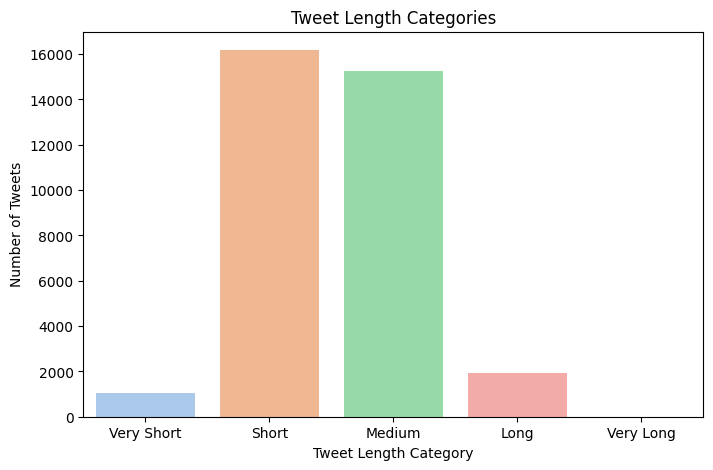

In [76]:
# Categorize tweets
bins = [0, 5, 15, 30, 50, 100]
labels = ['Very Short','Short','Medium','Long','Very Long']
data['length_category'] = pd.cut(data['text_len'], bins=bins, labels=labels, right=False)

# Countplot
plt.figure(figsize=(8,5))
sns.countplot(x='length_category', data=data, palette='pastel', order=labels)
plt.title('Tweet Length Categories')
plt.xlabel('Tweet Length Category')
plt.ylabel('Number of Tweets')
plt.show()

In [77]:
data.sort_values(by=['text_len'], ascending=False)

,tweet_text,cyberbullying_type,text_len,length_category
44035,black white trying live like nigger pahahahaha...,ethnicity,196,NaN
45165,hermdiggz tayyoung fuck obama dumb as nigger b...,ethnicity,171,NaN
1317,eurekalertas researcher push import top antibu...,not_cyberbullying,170,NaN
10922,do not make rape joke do not make gay joke oh ...,gender,147,NaN
33724,do not feel guilty killing feel guilty enjoyed...,age,141,NaN
...,...,...,...,...
1925,itsthedangtruth,not_cyberbullying,1,Very Short
3830,antonm,not_cyberbullying,1,Very Short
14445,tweetstatshashtagnotyourshieldmentionroguestarrt,gender,1,Very Short
7483,crock,not_cyberbullying,1,Very Short


## Data split

In [78]:
from sklearn.model_selection import train_test_split
X=data['tweet_text'].values
Y=data['cyberbullying_type'].values

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [81]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([['age', 6221],
       ['ethnicity', 5409],
       ['gender', 5329],
       ['not_cyberbullying', 4493],
       ['religion', 6089]], dtype=object)

### manual oversampling

In [82]:
import pandas as pd
from sklearn.utils import resample
import numpy as np

# Combine X_train and y_train
df_train = pd.DataFrame({'text': X_train, 'label': y_train})

# Find majority class
majority_class = df_train['label'].value_counts().idxmax()
print("Majority class:", majority_class)

# Separate classes
df_classes = [df_train[df_train.label == c] for c in df_train['label'].unique()]

# Oversample each class to match majority
df_oversampled_list = []
for df_class in df_classes:
    df_oversampled = resample(df_class,
                              replace=True,
                              n_samples=len(df_train[df_train.label == majority_class]),
                              random_state=42)
    df_oversampled_list.append(df_oversampled)

# Combine all
df_train_balanced = pd.concat(df_oversampled_list).sample(frac=1, random_state=42).reset_index(drop=True)

# Extract X and y
X_train_balanced = df_train_balanced['text'].values
y_train_balanced = df_train_balanced['label'].values

# Check distribution
(unique, counts) = np.unique(y_train_balanced, return_counts=True)
distribution = np.asarray((unique, counts)).T
print("Class distribution after proper oversampling:\n", distribution)


Majority class: age
Class distribution after proper oversampling:
 [['age' 6221]
 ['ethnicity' 6221]
 ['gender' 6221]
 ['not_cyberbullying' 6221]
 ['religion' 6221]]


## Vectorization

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
texts = data['tweet_text'].astype(str)

In [85]:
vectorizer = TfidfVectorizer() 
X=vectorizer.fit_transform(data['tweet_text'])

In [86]:
print("Vocabulary size:", len(vectorizer.get_feature_names_out()))
print("Feature names (sample):", vectorizer.get_feature_names_out()[:20]) 
print("TF-IDF Matrix Shape:", X.shape)

Vocabulary size: 45873
Feature names (sample): ['aa' 'aaa' 'aaaaaaaa' 'aaand' 'aaaw' 'aabhas' 'aadat' 'aadhar' 'aah'
 'aaj' 'aajakia' 'aak' 'aake' 'aalaameenmercy' 'aalawofficial'
 'aaliyahkotus' 'aalkayda' 'aalsilaalchisecularignorantselfish'
 'aalwuhaib' 'aamattyhealy']
TF-IDF Matrix Shape: (34427, 45873)


In [87]:
print(X[:10])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 63 stored elements and shape (10, 45873)>
  Coords	Values
  (0, 26626)	0.39738018706106987
  (0, 8955)	0.6199586662058055
  (0, 14481)	0.38488080506342914
  (0, 21837)	0.48171540057611784
  (0, 44833)	0.27849107323062344
  (1, 12850)	0.18975747595475395
  (1, 44803)	0.3620900575606411
  (1, 27588)	0.3312368066359675
  (1, 38757)	0.3484372765311161
  (1, 39048)	0.3620900575606411
  (1, 41187)	0.17994489128659022
  (1, 18990)	0.3387504742323191
  (1, 36506)	0.3484372765311161
  (1, 44366)	0.13088490099699873
  (1, 2864)	0.3620900575606411
  (1, 26626)	0.2320919484632792
  (2, 9308)	0.47543708754383074
  (2, 43241)	0.5171204684297567
  (2, 33389)	0.3477080816715772
  (2, 7550)	0.28304239218556865
  (2, 45168)	0.5527495735728535
  (3, 42175)	0.25103419651354786
  (3, 11768)	0.31386033334485813
  (3, 1731)	0.32556184452768405
  (3, 1844)	0.2503068990554607
  :	:
  (5, 13143)	0.30881971602405495
  (5, 31898)	0.31020380068108405
  

## BERT classification

### BERT Tokenization

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm.auto import tqdm


### Encode Labels

In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_balanced = le.fit_transform(y_train_balanced)
y_test = le.transform(y_test)


### Create PyTorch Dataset

In [90]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


### Model

In [95]:
def train_transformer(model_name, train_texts, val_texts, train_labels, val_labels,
                      batch_size=16, epochs=3, lr=2e-5, max_len=128, save_path="./model"):

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_ds = TextDataset(train_texts, train_labels, tokenizer, max_len)
    val_ds   = TextDataset(val_texts, val_labels, tokenizer, max_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(train_labels)))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\n🚀 Training {model_name}...\n")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**{k:batch[k] for k in batch if k!='labels'})
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            trues.extend(batch['labels'].cpu().numpy())

    acc = accuracy_score(trues, preds)
    print(f"\n✅ Validation Accuracy ({model_name}): {acc:.4f}")
    print(classification_report(trues, preds))

    # Save model
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"💾 Model saved at {save_path}")

    return model, tokenizer


In [96]:
bert_model, bert_tokenizer = train_transformer(
    model_name='bert-base-uncased',
    train_texts=X_train_balanced,
    val_texts=X_test,
    train_labels=y_train_balanced,
    val_labels=y_test,
    epochs=3,
    batch_size=16,
    save_path='./bert_model'
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Training bert-base-uncased...



Epoch 1:   0%|          | 0/1945 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.2298


Epoch 2:   0%|          | 0/1945 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.0725


Epoch 3:   0%|          | 0/1945 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.0248

✅ Validation Accuracy (bert-base-uncased): 0.9522
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1555
           1       0.99      0.99      0.99      1352
           2       0.95      0.92      0.93      1333
           3       0.86      0.88      0.87      1124
           4       0.97      0.97      0.97      1522

    accuracy                           0.95      6886
   macro avg       0.95      0.95      0.95      6886
weighted avg       0.95      0.95      0.95      6886

💾 Model saved at ./bert_model


In [98]:
print("\n🔹 Evaluating BERT on test data...")

bert_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

bert_test_ds = TextDataset(X_test.tolist(), y_test.tolist(), bert_tokenizer)
bert_test_loader = DataLoader(bert_test_ds, batch_size=16)

preds, trues = [], []
with torch.no_grad():
    for batch in bert_test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = bert_model(**{k: batch[k] for k in batch if k != 'labels'})
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(batch['labels'].cpu().numpy())

print("✅ BERT Test Accuracy:", accuracy_score(trues, preds))
print(classification_report(trues, preds))



🔹 Evaluating BERT on test data...
✅ BERT Test Accuracy: 0.9522218995062446
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1555
           1       0.99      0.99      0.99      1352
           2       0.95      0.92      0.93      1333
           3       0.86      0.88      0.87      1124
           4       0.97      0.97      0.97      1522

    accuracy                           0.95      6886
   macro avg       0.95      0.95      0.95      6886
weighted avg       0.95      0.95      0.95      6886



In [ ]:
# Evaluation (test)
model.eval()
preds, trues = [], []
with torch.no_grad():   
    for batch in test_loader:        # using test_loader from above
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        trues.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(trues, preds))
print(classification_report(trues, preds, target_names=le.classes_))


# RoBERTa

In [114]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW 
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

### PyTorch Dataset class

In [115]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

### Training Function

In [116]:

def train_roberta(model_name, train_texts, val_texts, train_labels, val_labels,
                  batch_size=16, epochs=3, lr=2e-5, max_len=128, save_path="./roberta_model"):

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_ds = TextDataset(train_texts, train_labels, tokenizer, max_len)
    val_ds   = TextDataset(val_texts, val_labels, tokenizer, max_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(set(train_labels))
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\n🚀 Training {model_name}...\n")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**{k: batch[k] for k in batch if k != 'labels'})
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            trues.extend(batch['labels'].cpu().numpy())

    acc = accuracy_score(trues, preds)
    print(f"\n✅ Validation Accuracy ({model_name}): {acc:.4f}")
    print(classification_report(trues, preds))

    # Save model
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"💾 Model saved at {save_path}")

    return model, tokenizer

### Model 

In [117]:

# --- Train RoBERTa --- 
roberta_model, roberta_tokenizer = train_roberta(
    model_name='roberta-base',
    train_texts=X_train_balanced,
    val_texts=X_test,
    train_labels=y_train_balanced,
    val_labels=y_test,
    epochs=3,
    batch_size=16,
    save_path='./roberta_model'
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Training roberta-base...



Epoch 1: 100%|██████████| 1945/1945 [06:41<00:00,  4.84it/s]


Epoch 1 | Loss: 0.2374


Epoch 2: 100%|██████████| 1945/1945 [06:42<00:00,  4.84it/s]


Epoch 2 | Loss: 0.1102


Epoch 3: 100%|██████████| 1945/1945 [06:42<00:00,  4.84it/s]


Epoch 3 | Loss: 0.0550

✅ Validation Accuracy (roberta-base): 0.9492
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1555
           1       0.99      0.99      0.99      1352
           2       0.95      0.91      0.93      1333
           3       0.85      0.88      0.86      1124
           4       0.96      0.97      0.97      1522

    accuracy                           0.95      6886
   macro avg       0.94      0.95      0.94      6886
weighted avg       0.95      0.95      0.95      6886

💾 Model saved at ./roberta_model


### Evaluation

In [118]:
# --- Evaluation on test set ---
roberta_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.to(device)

roberta_test_ds = TextDataset(X_test.tolist(), y_test.tolist(), roberta_tokenizer)
roberta_test_loader = DataLoader(roberta_test_ds, batch_size=16)

preds, trues = [], []
with torch.no_grad():
    for batch in roberta_test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = roberta_model(**{k: batch[k] for k in batch if k != 'labels'})
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(batch['labels'].cpu().numpy())

print("✅ RoBERTa Test Accuracy:", accuracy_score(trues, preds))
print(classification_report(trues, preds)) 

✅ RoBERTa Test Accuracy: 0.9491722335172814
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1555
           1       0.99      0.99      0.99      1352
           2       0.95      0.91      0.93      1333
           3       0.85      0.88      0.86      1124
           4       0.96      0.97      0.97      1522

    accuracy                           0.95      6886
   macro avg       0.94      0.95      0.94      6886
weighted avg       0.95      0.95      0.95      6886



### Classification Report

# Ensemble BERT and RoBERTa

In [119]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report


In [125]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [126]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load BERT
bert_model = AutoModelForSequenceClassification.from_pretrained('./bert_model')
bert_tokenizer = AutoTokenizer.from_pretrained('./bert_model')

# Load RoBERTa
roberta_model = AutoModelForSequenceClassification.from_pretrained('./roberta_model')
roberta_tokenizer = AutoTokenizer.from_pretrained('./roberta_model')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
roberta_model.to(device)
bert_model.eval()
roberta_model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [127]:
# validation accuracy
bert_val_acc = 0.9522
roberta_val_acc = 0.9492

total = bert_val_acc + roberta_val_acc
bert_weight = bert_val_acc / total
roberta_weight = roberta_val_acc / total

print("BERT weight:", bert_weight)
print("RoBERTa weight:", roberta_weight)


BERT weight: 0.5007888923950773
RoBERTa weight: 0.49921110760492265


### Weighted Soft Voting Ensemble Prediction

In [128]:
test_ds = TextDataset(X_test.tolist(), y_test.tolist(), bert_tokenizer)
test_loader = DataLoader(test_ds, batch_size=16)

ensemble_preds = []
trues = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        trues.extend(batch['labels'].cpu().numpy())

        # BERT probabilities
        bert_outputs = bert_model(**{k: batch[k] for k in batch if k != 'labels'})
        bert_probs = F.softmax(bert_outputs.logits, dim=1)

        # RoBERTa probabilities
        texts = [X_test[i + batch_idx*test_loader.batch_size] for i in range(len(batch['labels']))]
        roberta_enc = roberta_tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        ).to(device)
        roberta_outputs = roberta_model(**roberta_enc)
        roberta_probs = F.softmax(roberta_outputs.logits, dim=1)

        # Weighted soft voting
        avg_probs = bert_weight*bert_probs + roberta_weight*roberta_probs
        preds = torch.argmax(avg_probs, dim=1)
        ensemble_preds.extend(preds.cpu().numpy())


In [129]:
print("✅ Weighted Soft Voting Accuracy:", accuracy_score(trues, ensemble_preds))
print(classification_report(trues, ensemble_preds))


✅ Weighted Soft Voting Accuracy: 0.9555620098751089
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1555
           1       0.99      0.99      0.99      1352
           2       0.96      0.92      0.94      1333
           3       0.86      0.90      0.88      1124
           4       0.96      0.97      0.97      1522

    accuracy                           0.96      6886
   macro avg       0.95      0.95      0.95      6886
weighted avg       0.96      0.96      0.96      6886



### Adding hidden-state fusion classifier(Experiment)